In [ ]:
!pip install matplotlib --upgrade

In [ ]:
!pip install holidays_es

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
from sqlalchemy import create_engine
import seaborn as sns
from datetime import timedelta, date, datetime
from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from holidays_es import Province
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

In [ ]:
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [ ]:
from google.colab import files
import io
uploaded = files.upload()

Saving Global DataBase3.csv to Global DataBase3.csv


In [ ]:
#read dataframe from DB
df=pd.read_csv(io.BytesIO(uploaded['Global DataBase2 daily.csv']), index_col='datetime', parse_dates=True, dayfirst = True)

df = df.sort_index()

#Handeling global outliers
GlobalOutliers =  []
for i in range(0):
    GlobalOutliers.append(df.idxmax()['Price - PT [€/MWh]'])
    df.at[df.idxmax()['Price - PT [€/MWh]'], 'Price - PT [€/MWh]'] = np.nan

#Replacing them with the mean of that day
for d in GlobalOutliers:
    sdt = datetime.combine(d, datetime.min.time())
    edt = sdt + timedelta(hours=24)
    df.at[d, 'Price - PT [€/MWh]'] = df[sdt:edt]['Price - PT [€/MWh]'].mean()
    
    
#Handling negative values 
negativeIndex = df.index[df['Price - PT [€/MWh]'] < 0]
for index in (negativeIndex):
    df.at[index, 'Price - PT [€/MWh]']= df.at[index - timedelta(hours=1), 'Price - PT [€/MWh]']

df = df.dropna()

In [ ]:
df.drop(['Price - ES [€/MWh]'],  axis=1, inplace=True )
df.drop(['Actual Consumption (MWh)'],  axis=1, inplace=True )
df

,Price - PT [€/MWh],Biomass AA,Fossil Gas AA,Fossil Hard Coal AC,Hydro Pumped Storage AA,Hydro Pumped Storage AC,Hydro Run-of-river and poundage AA,Hydro Water Reservoir AA,Other AA,Solar AA,Wind Onshore AA,Electricity Consumption (MWh),Season
datetime,,,,,,,,,,,,,
2017-01-01 01:00:00,58.82,355.0,1654,0,168,5,335,0,41,0,325,5302,1
2017-01-01 02:00:00,58.23,358.0,999,0,157,6,218,0,41,0,374,5077,1
2017-01-01 03:00:00,51.95,358.0,805,0,101,60,248,0,40,0,420,4875,1
2017-01-01 04:00:00,47.27,352.0,668,0,100,33,184,0,40,0,433,4561,1
2017-01-01 05:00:00,46.90,357.0,357,0,0,663,190,3,41,0,450,4271,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-15 19:00:00,277.80,400.0,1623,0,117,228,1162,214,33,65,756,5434,2
2022-03-15 20:00:00,297.01,403.0,1594,0,918,4,1707,675,33,6,907,5977,2
2022-03-15 21:00:00,311.71,406.0,1579,0,1544,1,2012,824,33,0,1012,6144,2


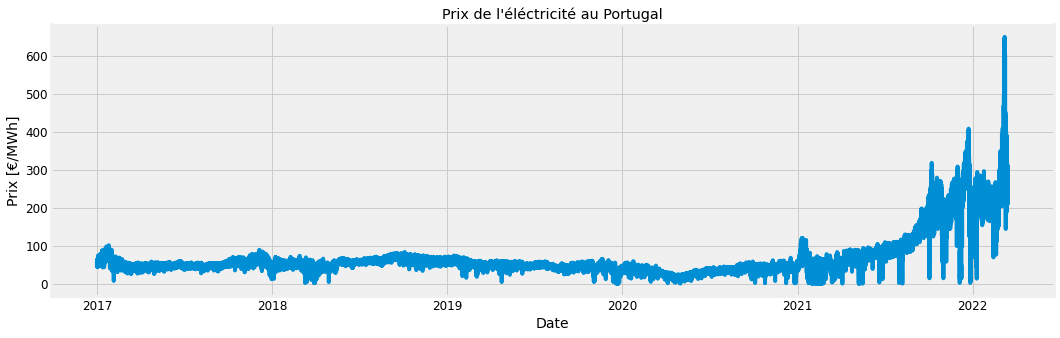

In [ ]:
plt.figure(figsize=(16,5))
plt.gca().set(title="Prix de l'éléctricité au Portugal", xlabel='Date', ylabel='Prix [€/MWh]')
plt.plot(df.index, df['Price - PT [€/MWh]']) 
plt.show()

In [ ]:
#Détecter les valeurs négatives
df.describe()

,Price - PT [€/MWh],Biomass AA,Fossil Gas AA,Fossil Hard Coal AC,Hydro Pumped Storage AA,Hydro Pumped Storage AC,Hydro Run-of-river and poundage AA,Hydro Water Reservoir AA,Other AA,Solar AA,Wind Onshore AA,Electricity Consumption (MWh),Season
count,45599.000000,45599.000000,45599.000000,45599.000000,45599.000000,45599.000000,45599.000000,45599.000000,45599.000000,45599.000000,45599.000000,45599.000000,45599.000000
mean,67.283131,332.869999,1820.334042,6.096691,353.004320,228.691923,687.053400,268.419286,40.395096,134.197767,1435.644751,4915.562929,2.474747
std,56.321374,55.063932,957.755048,7.434216,487.200673,425.220346,617.784479,310.741234,25.742778,195.733151,1063.001343,736.138818,1.122001
min,0.000000,76.000000,160.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.000000,0.000000,4.000000,3816.000000,1.000000
25%,41.100000,311.000000,1002.000000,0.000000,0.000000,3.000000,193.000000,35.000000,29.000000,0.000000,575.000000,4220.000000,1.000000
50%,51.920000,340.000000,1788.000000,5.000000,110.000000,7.000000,507.000000,135.000000,34.000000,3.000000,1169.000000,4875.000000,2.000000
75%,66.190000,376.000000,2599.000000,9.000000,550.000000,251.000000,1026.000000,416.000000,38.000000,246.000000,2099.000000,5302.000000,3.000000
max,651.000000,433.000000,4373.000000,66.000000,2392.000000,2503.000000,2718.000000,1398.000000,165.000000,1142.000000,4714.000000,6207.000000,4.000000


In [ ]:
#Données manquantes 

df.isnull().values.any()

False

In [ ]:
#Ajout des attributs supplémentaires  : Mois, type du jour, jour férié

def add_extra_attributes(df): 
    holidays= []
    holidays.append(Province(name="malaga",year=2017).holidays().get('local_holidays'))
    holidays.append(Province(name="malaga",year=2017).holidays().get('national_holidays'))
    holidays.append(Province(name="malaga",year=2017).holidays().get('regional_holidays'))

    
    holidays.append(Province(name="malaga",year=2018).holidays().get('local_holidays'))
    holidays.append(Province(name="malaga",year=2018).holidays().get('national_holidays'))
    holidays.append(Province(name="malaga",year=2018).holidays().get('regional_holidays'))

    holidays.append(Province(name="malaga",year=2019).holidays().get('local_holidays'))
    holidays.append(Province(name="malaga",year=2019).holidays().get('national_holidays'))
    holidays.append(Province(name="malaga",year=2019).holidays().get('regional_holidays'))

    holidays.append(Province(name="malaga",year=2020).holidays().get('local_holidays'))
    holidays.append(Province(name="malaga",year=2020).holidays().get('national_holidays'))
    holidays.append(Province(name="malaga",year=2020).holidays().get('regional_holidays'))

    holidays.append(Province(name="malaga",year=2021).holidays().get('local_holidays'))
    holidays.append(Province(name="malaga",year=2021).holidays().get('national_holidays'))
    holidays.append(Province(name="malaga",year=2021).holidays().get('regional_holidays'))

    holidays.append(Province(name="malaga",year=2022).holidays().get('local_holidays'))
    holidays.append(Province(name="malaga",year=2022).holidays().get('national_holidays'))
    holidays.append(Province(name="malaga",year=2022).holidays().get('regional_holidays'))
    
    holidays_dates=[]
    for i in range (len(holidays)):
        for j in range (len(holidays[i])):
            holidays_dates.append(holidays[i][j])
    df_holidays=pd.DataFrame({'Holidays': holidays_dates})

    df['holiday'] =0
    df['weekday']=0
    df['month']=0

    for i in range (len(df.index)):
        if (df.index[i].weekday() == 5 or df.index[i].weekday() == 6):
            df['weekday'][i]=1
        df['month'][i]= df.index[i].month
            
        for j in range (len(df_holidays)):
            if (df.index[i] == df_holidays['Holidays'][j]):
                df['holiday'][i]=1
    return df      


df_extra=add_extra_attributes(df)

In [ ]:
df=df_extra[['Biomass AA', 'Fossil Gas AA', 'Fossil Hard Coal AC','Hydro Pumped Storage AA', 'Hydro Pumped Storage AC','Hydro Run-of-river and poundage AA', 'Hydro Water Reservoir AA','Other AA', 'Solar AA', 'Wind Onshore AA','Electricity Consumption (MWh)','holiday','weekday','month','Price - PT [€/MWh]']].dropna()

df

,Biomass AA,Fossil Gas AA,Fossil Hard Coal AC,Hydro Pumped Storage AA,Hydro Pumped Storage AC,Hydro Run-of-river and poundage AA,Hydro Water Reservoir AA,Other AA,Solar AA,Wind Onshore AA,Electricity Consumption (MWh),holiday,weekday,month,Price - PT [€/MWh]
datetime,,,,,,,,,,,,,,,
2017-01-01 01:00:00,355.0,1654,0,168,5,335,0,41,0,325,5302,0,1,1,58.82
2017-01-01 02:00:00,358.0,999,0,157,6,218,0,41,0,374,5077,0,1,1,58.23
2017-01-01 03:00:00,358.0,805,0,101,60,248,0,40,0,420,4875,0,1,1,51.95
2017-01-01 04:00:00,352.0,668,0,100,33,184,0,40,0,433,4561,0,1,1,47.27
2017-01-01 05:00:00,357.0,357,0,0,663,190,3,41,0,450,4271,0,1,1,46.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-15 19:00:00,400.0,1623,0,117,228,1162,214,33,65,756,5434,0,0,3,277.80
2022-03-15 20:00:00,403.0,1594,0,918,4,1707,675,33,6,907,5977,0,0,3,297.01
2022-03-15 21:00:00,406.0,1579,0,1544,1,2012,824,33,0,1012,6144,0,0,3,311.71


In [ ]:
from pylab import rcParams

def eval_model(train_y, pred_ytrain, test_y, pred_y, model, att):
    rcParams['figure.figsize'] = 14, 6

    scores = [[ metrics.mean_absolute_error(train_y, pred_ytrain),  np.sqrt(metrics.mean_squared_error(train_y, pred_ytrain)), np.sqrt(metrics.mean_squared_error(train_y, pred_ytrain))/train_y.mean()],
    [ metrics.mean_absolute_error(test_y, pred_y),  np.sqrt(metrics.mean_squared_error(test_y, pred_y)), np.sqrt(metrics.mean_squared_error(test_y, pred_y))/test_y.mean()]]

    labels = ['MAE', 'RMSE', 'CV']

    p = np.arange(len(labels))

    width = 0.25

    fig, ax = plt.subplots()

    rects1 = ax.bar(p - width/2, scores[0], width, label='Train')
    rects2 = ax.bar(p + width/2, scores[1], width, label='Test')

    ax.set_title( model + ' Model - ' + att + ' attribute selection')
    ax.set_xticks(p)
    ax.set_xticklabels(labels)
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()

    plt.show() 

In [ ]:
def print_results(train_y, pred_ytrain, test_y, pred_y, exec_time):
    print('************* Train results *************')

    print('Mean Absolute Error:', '%.5f' %  metrics.mean_absolute_error(train_y, pred_ytrain))
    print('Root Mean Squared Error:','%.5f' %  np.sqrt(metrics.mean_squared_error(train_y, pred_ytrain)))
    print('Coefficient of Variance:', '%.5f' %  ((np.sqrt(metrics.mean_squared_error(train_y, pred_ytrain))/train_y.mean())*100))

    print('************* Test results *************')

    print('Mean Absolute Error:', '%.5f' % metrics.mean_absolute_error(test_y, pred_y))
    print('Root Mean Squared Error:', '%.5f' % np.sqrt(metrics.mean_squared_error(test_y, pred_y)))
    print('Coefficient of Variance:', '%.5f' % ((np.sqrt(metrics.mean_squared_error(test_y, pred_y))/test_y.mean())*100))
    print('R2' , '%.5f' % metrics.r2_score(train_y, pred_ytrain))
    
    print('****************************************')
    print('Execution Time:', '%.5f' %  exec_time)

In [ ]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


### XGBRegressor

In [ ]:
import xgboost as xgb

X = df.values[:, :-1] #Features
y = df.values[:, -1] #output

xgbr = xgb.XGBRegressor(verbosity=0)
xgbr.fit(X, y)

feature_names = np.array(df[['Biomass AA', 'Fossil Gas AA', 'Fossil Hard Coal AC','Hydro Pumped Storage AA', 'Hydro Pumped Storage AC','Hydro Run-of-river and poundage AA', 'Hydro Water Reservoir AA','Other AA', 'Solar AA', 'Wind Onshore AA','Electricity Consumption (MWh)' ,'holiday', 'weekday', 'month']].columns)
sfs_forward = SequentialFeatureSelector(xgbr, n_features_to_select=7, direction='forward').fit(X, y)
print("Features selected by forward sequential selection: "  f"{feature_names[sfs_forward.get_support()]}")
sfs_backward = SequentialFeatureSelector(xgbr, n_features_to_select=7, direction='backward').fit(X, y)
print("Features selected by backward sequential selection: "  f"{feature_names[sfs_backward.get_support()]}")

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.15)

xgbr = xgb.XGBRegressor(verbosity=0)
start_time = time.time()
xgbr.fit(xtrain, ytrain)
exec_time = time.time()-start_time

ypredtr = xgbr.predict(xtrain)
ypredts = xgbr.predict(xtest)
print_results(ytrain, ypredtr, ytest, ypredts, exec_time)

Features selected by forward sequential selection: ['Hydro Pumped Storage AA' 'Hydro Pumped Storage AC' 'Solar AA'
 'Wind Onshore AA' 'Electricity Consumption (MWh)' 'holiday' 'weekday']
Features selected by backward sequential selection: ['Biomass AA' 'Fossil Hard Coal AC' 'Hydro Pumped Storage AA'
 'Hydro Run-of-river and poundage AA' 'Solar AA' 'Wind Onshore AA'
 'Electricity Consumption (MWh)']
************* Train results *************
Mean Absolute Error: 7.64390
Root Mean Squared Error: 13.33749
Coefficient of Variance: 19.76449
************* Test results *************
Mean Absolute Error: 9.66768
Root Mean Squared Error: 18.20210
Coefficient of Variance: 27.51399
R2 0.94438
****************************************
Execution Time: 1.50877


In [ ]:
X = sfs_backward.transform(X) 

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.15)

xgbr = xgb.XGBRegressor(verbosity=0)
start_time = time.time()
xgbr.fit(xtrain, ytrain)
exec_time = time.time()-start_time

ypredtr = xgbr.predict(xtrain)
ypredts = xgbr.predict(xtest)
print_results(ytrain, ypredtr, ytest, ypredts, exec_time)

************* Train results *************
Mean Absolute Error: 13.44235
Root Mean Squared Error: 24.02638
Coefficient of Variance: 35.68846
************* Test results *************
Mean Absolute Error: 16.80968
Root Mean Squared Error: 31.51453
Coefficient of Variance: 46.99465
R2 0.81763
****************************************
Execution Time: 1.09766


### MLR

In [ ]:
X = df.values[:, :-1] #Features
y = df.values[:, -1] #output

#Normalisation
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [ ]:
reg=linear_model.LinearRegression()
reg.fit(X, y)

feature_names = np.array(df[['Biomass AA', 'Fossil Gas AA', 'Fossil Hard Coal AC','Hydro Pumped Storage AA', 'Hydro Pumped Storage AC','Hydro Run-of-river and poundage AA', 'Hydro Water Reservoir AA','Other AA', 'Solar AA', 'Wind Onshore AA','Electricity Consumption (MWh)' ,'holiday', 'weekday', 'month']].columns)
sfs_forward = SequentialFeatureSelector(reg, n_features_to_select=7, direction='forward').fit(X, y)
print("Features selected by forward sequential selection: "  f"{feature_names[sfs_forward.get_support()]}")
sfs_backward = SequentialFeatureSelector(reg, n_features_to_select=7, direction='backward').fit(X, y)
print("Features selected by backward sequential selection: "  f"{feature_names[sfs_backward.get_support()]}")

Features selected by forward sequential selection: ['Hydro Pumped Storage AC' 'Hydro Water Reservoir AA' 'Solar AA'
 'Electricity Consumption (MWh)' 'holiday' 'weekday' 'month']
Features selected by backward sequential selection: ['Hydro Pumped Storage AC' 'Hydro Water Reservoir AA' 'Solar AA'
 'Electricity Consumption (MWh)' 'holiday' 'weekday' 'month']


In [ ]:
train_X, test_X, train_y, test_y = train_test_split( X, y, test_size = 0.33)

reg = linear_model.LinearRegression()

start_time = time.time()
model = reg.fit(train_X, train_y)
exec_time = time.time()-start_time
pred_y = model.predict(test_X)
pred_ytrain = model.predict(train_X)

In [ ]:
print_results(train_y, pred_ytrain, test_y, pred_y, exec_time)

************* Train results *************
Mean Absolute Error: 32.07051
Root Mean Squared Error: 49.84791
Coefficient of Variance: 74.45034
************* Test results *************
Mean Absolute Error: 32.79359
Root Mean Squared Error: 51.58270
Coefficient of Variance: 75.91254
R2 0.19701
****************************************
Execution Time: 0.03264


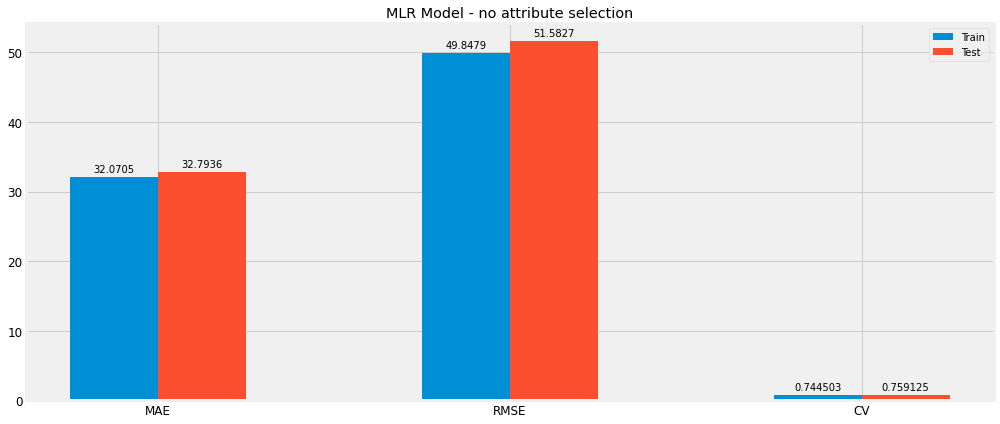

In [ ]:
eval_model(train_y, pred_ytrain, test_y, pred_y, "MLR", "no")

#### Selection d'attributs

In [ ]:
#Features selection 
X = sfs_backward.transform(X) 

train_X, test_X, train_y, test_y = train_test_split( X, y, test_size = 0.33)

reg = linear_model.LinearRegression()

start_time = time.time()
model = reg.fit(train_X, train_y)
exec_time = time.time()-start_time
pred_y = model.predict(test_X)
pred_ytrain = model.predict(train_X)

In [ ]:
print_results(train_y, pred_ytrain, test_y, pred_y, exec_time)

************* Train results *************
Mean Absolute Error: 32.66551
Root Mean Squared Error: 55.33749
Coefficient of Variance: 82.22976
************* Test results *************
Mean Absolute Error: 32.70894
Root Mean Squared Error: 55.26780
Coefficient of Variance: 82.17450
R2 0.03763
****************************************
Execution Time: 0.02375


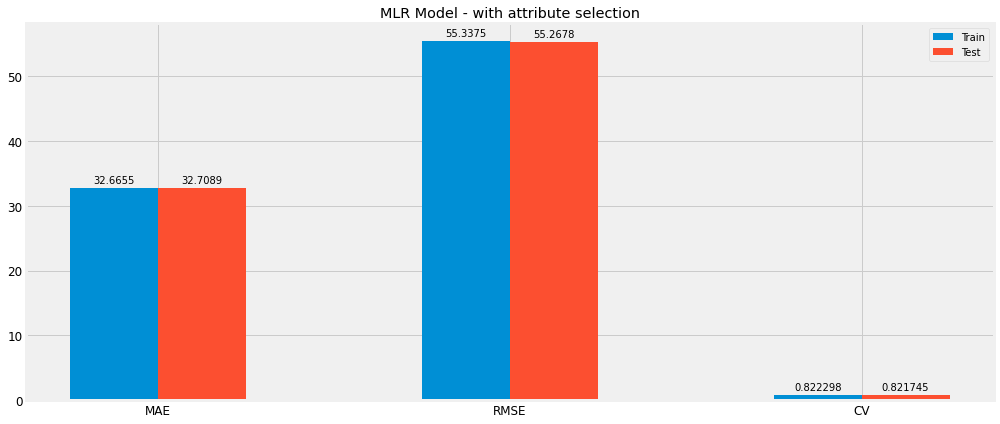

In [ ]:
eval_model(train_y, pred_ytrain, test_y, pred_y, "MLR", "with")

### SVR

In [ ]:
df=df_extra[[ 'Biomass AA', 'Fossil Gas AA', 'Fossil Hard Coal AC','Hydro Pumped Storage AA', 'Hydro Pumped Storage AC','Hydro Run-of-river and poundage AA', 'Hydro Water Reservoir AA','Other AA', 'Solar AA', 'Wind Onshore AA','Electricity Consumption (MWh)' ,'holiday', 'weekday', 'month', 'Price - PT [€/MWh]']]

X = df.values[:, :-1] #Features
y = df.values[:, -1] #output

#Normalisation
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [ ]:
train_X, test_X, train_y, test_y = train_test_split( X, y, test_size = 0.33)

params = {'kernel': ('linear','poly','rbf'),
          'C':[0.01,0.1,1,10],
          'gamma': [1e-7, 1e-4, 0.001, 0.1, 1],
          'epsilon':[0.1,0.2,0.3,0.5]}

svr = SVR()

grid_search = GridSearchCV(svr, param_grid=params ,cv=10, n_jobs=-1, verbose=0)
start_time = time.time()
grid_search.fit(train_X, train_y)
exec_time = time.time()-start_time

print(grid_search.best_params_)

model = grid_search.best_estimator_
pred_y = model.predict(test_X)

pred_ytrain = model.predict(train_X)

{'C': 10, 'epsilon': 0.5, 'gamma': 1, 'kernel': 'poly'}


In [ ]:
print_results(train_y, pred_ytrain, test_y, pred_y, exec_time)

************* Train results *************
Mean Absolute Error: 21.03299
Root Mean Squared Error: 45.08562
Coefficient of Variance: 67.00058
************* Test results *************
Mean Absolute Error: 21.20096
Root Mean Squared Error: 45.55542
Coefficient of Variance: 67.72393
R2 0.35495
****************************************
Execution Time: 28744.01910


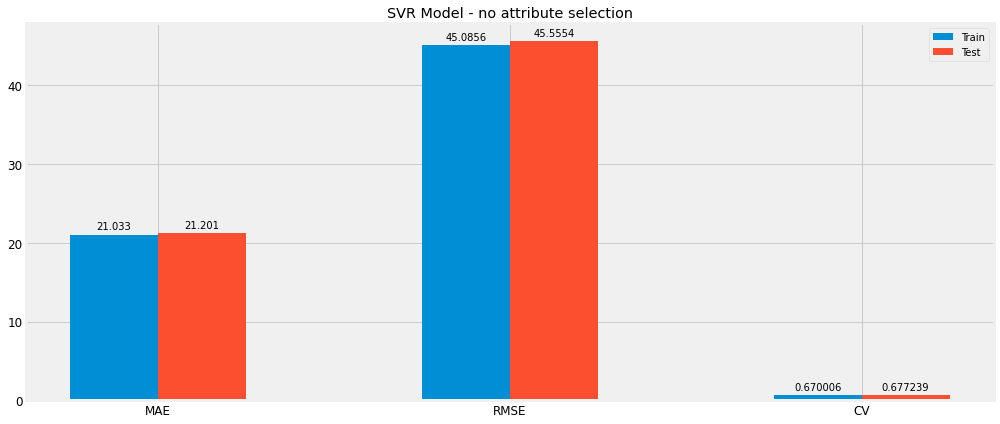

In [ ]:
eval_model(train_y, pred_ytrain, test_y, pred_y, "SVR", "no")

Selection d'attributs

In [ ]:
svr=SVR()
svr.fit(X, y)

feature_names = np.array(df[['Biomass AA', 'Fossil Gas AA', 'Fossil Hard Coal AC','Hydro Pumped Storage AA', 'Hydro Pumped Storage AC','Hydro Run-of-river and poundage AA', 'Hydro Water Reservoir AA','Other AA', 'Solar AA', 'Wind Onshore AA','Electricity Consumption (MWh)' ,'holiday', 'weekday', 'month']].columns)
sfs_forward = SequentialFeatureSelector(svr, n_features_to_select=7, direction='forward').fit(X, y)
print("Features selected by forward sequential selection: "  f"{feature_names[sfs_forward.get_support()]}")
sfs_backward = SequentialFeatureSelector(svr, n_features_to_select=7, direction='backward').fit(X, y)
print("Features selected by backward sequential selection: "  f"{feature_names[sfs_backward.get_support()]}")

Features selected by forward sequential selection: ['Fossil Gas AA' 'Fossil Hard Coal AC' 'Hydro Pumped Storage AC'
 'Other AA' 'Electricity Consumption (MWh)' 'holiday' 'weekday']
Features selected by backward sequential selection: ['Fossil Gas AA' 'Fossil Hard Coal AC' 'Hydro Pumped Storage AA'
 'Hydro Pumped Storage AC' 'Other AA' 'Electricity Consumption (MWh)'
 'weekday']


In [ ]:
#Features selection 
X = sfs_backward.transform(X) 

train_X, test_X, train_y, test_y = train_test_split( X, y, test_size=0.44)

grid_search = GridSearchCV(svr, param_grid=params ,cv=10, n_jobs=-1, verbose=0)
start_time=time.time()
grid_search.fit(train_X, train_y)
exec_time= time.time()-start_time

print(grid_search.best_params_)

model=grid_search.best_estimator_
pred_y=model.predict(test_X)

pred_ytrain=model.predict(train_X)

{'C': 10, 'epsilon': 0.1, 'gamma': 1, 'kernel': 'rbf'}


In [ ]:
print_results(train_y, pred_ytrain, test_y, pred_y, exec_time)

************* Train results *************
Mean Absolute Error: 25.71261
Root Mean Squared Error: 56.76153
Coefficient of Variance: 83.54384
************* Test results *************
Mean Absolute Error: 24.60394
Root Mean Squared Error: 54.47550
Coefficient of Variance: 81.98667
R2 0.01389
****************************************
Execution Time: 18380.79306


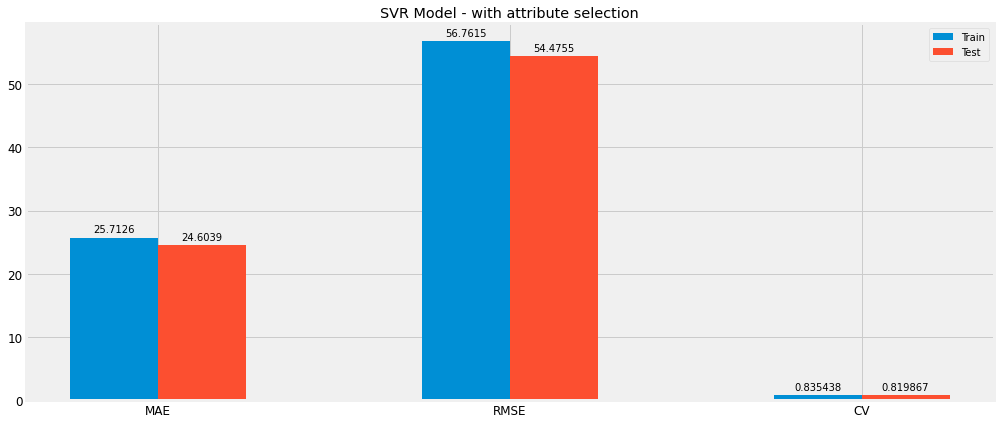

In [ ]:
eval_model(train_y, pred_ytrain, test_y, pred_y, "SVR", "with")

RF

In [ ]:
df=df_extra[['Biomass AA', 'Fossil Gas AA', 'Fossil Hard Coal AC','Hydro Pumped Storage AA', 'Hydro Pumped Storage AC','Hydro Run-of-river and poundage AA', 'Hydro Water Reservoir AA','Other AA', 'Solar AA', 'Wind Onshore AA','Electricity Consumption (MWh)' ,'holiday', 'weekday', 'month','Price - PT [€/MWh]']]

X=df.values[:, :-1] #Features
y=df.values[:, -1] #output

#Normalisation
scaler=MinMaxScaler()
X=scaler.fit_transform(X)

In [ ]:
train_X, test_X, train_y, test_y = train_test_split( X, y, test_size = 0.33)

#Parameters Tunning
params = { 'n_estimators': [200, 500], 'max_features': ['auto', 'sqrt'], 'max_depth' : [4,5,6,7,8,10],'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10]}

rf=RandomForestRegressor()

grid_search = GridSearchCV(rf, param_grid=params ,cv=10, n_jobs=-1, verbose=0)
start_time = time.time()
grid_search.fit(train_X, train_y)
exec_time = time.time()-start_time

print(grid_search.best_params_)

model=grid_search.best_estimator_
pred_y=model.predict(test_X)

pred_ytrain=model.predict(train_X)

{'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


In [ ]:
print_results(train_y, pred_ytrain, test_y, pred_y, exec_time)

************* Train results *************
Mean Absolute Error: 7.86707
Root Mean Squared Error: 15.17356
Coefficient of Variance: 22.65107
************* Test results *************
Mean Absolute Error: 9.38289
Root Mean Squared Error: 19.71296
Coefficient of Variance: 29.04015
R2 0.92641
****************************************
Execution Time: 7972.59894


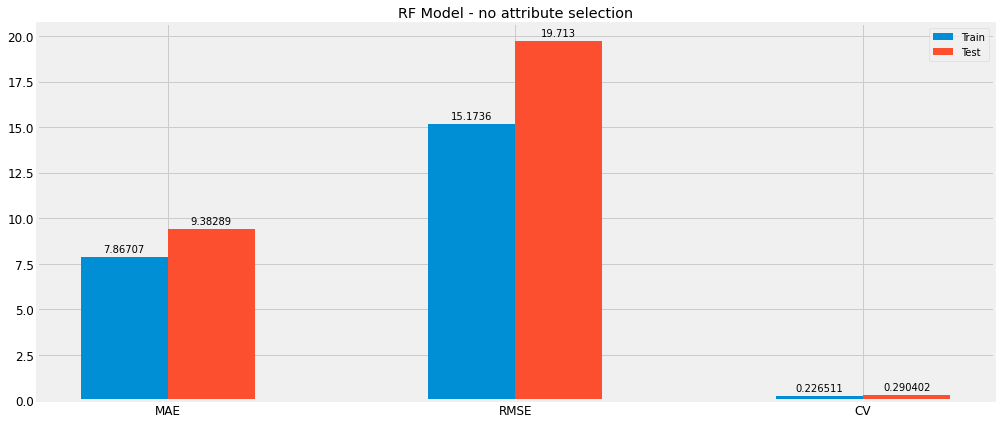

In [ ]:
eval_model(train_y, pred_ytrain, test_y, pred_y, "RF", "no")

Selection d'attributs

In [ ]:
rf=RandomForestRegressor()
rf.fit(X, y)

feature_names = np.array(df[[ 'Biomass AA', 'Fossil Gas AA', 'Fossil Hard Coal AC','Hydro Pumped Storage AA', 'Hydro Pumped Storage AC','Hydro Run-of-river and poundage AA', 'Hydro Water Reservoir AA','Other AA', 'Solar AA', 'Wind Onshore AA','Electricity Consumption (MWh)' ,'holiday', 'weekday', 'month']].columns)
sfs_forward = SequentialFeatureSelector(rf, n_features_to_select=7, direction='forward').fit(X, y)
print("Features selected by forward sequential selection: "  f"{feature_names[sfs_forward.get_support()]}")
sfs_backward = SequentialFeatureSelector(rf, n_features_to_select=7, direction='backward').fit(X, y)
print("Features selected by backward sequential selection: "  f"{feature_names[sfs_backward.get_support()]}")

Features selected by forward sequential selection: ['Hydro Pumped Storage AC' 'Solar AA' 'Wind Onshore AA'
 'Electricity Consumption (MWh)' 'holiday' 'weekday' 'month']
Features selected by backward sequential selection: ['Biomass AA' 'Fossil Hard Coal AC' 'Hydro Pumped Storage AA'
 'Hydro Run-of-river and poundage AA' 'Hydro Water Reservoir AA'
 'Other AA' 'Wind Onshore AA']


In [ ]:
#Features selection 
X = sfs_backward.transform(X) 

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.44)
rf=RandomForestRegressor()

grid_search = GridSearchCV(rf, param_grid=params ,cv=10, n_jobs=-1, verbose=0)
start_time=time.time()
grid_search.fit(train_X, train_y)
exec_time= time.time()-start_time

model=grid_search.best_estimator_
pred_y=model.predict(test_X)

print(grid_search.best_params_)

pred_ytrain=model.predict(train_X)

{'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [ ]:
print_results(train_y, pred_ytrain, test_y, pred_y, exec_time)

************* Train results *************
Mean Absolute Error: 13.42987
Root Mean Squared Error: 26.14847
Coefficient of Variance: 38.96171
************* Test results *************
Mean Absolute Error: 15.57205
Root Mean Squared Error: 30.19464
Coefficient of Variance: 44.73324
R2 0.78391
****************************************
Execution Time: 4408.15247


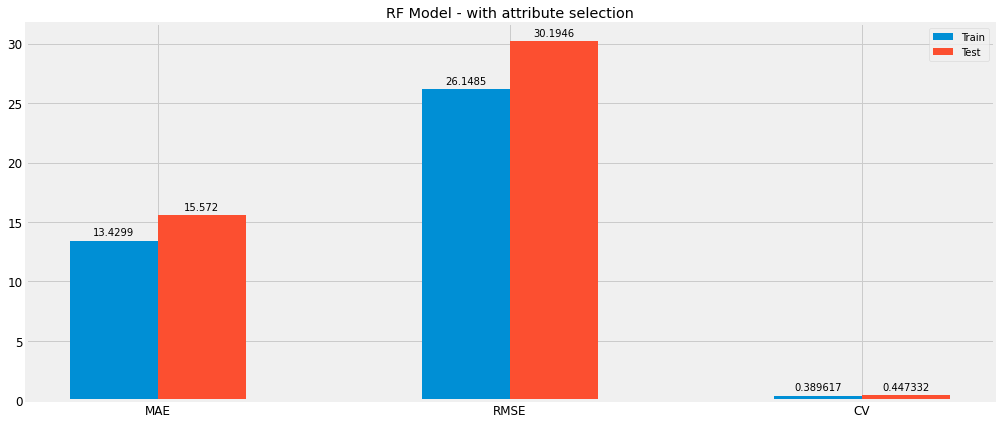

In [ ]:
eval_model(train_y, pred_ytrain, test_y, pred_y, "RF", "with")